In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import torch

class TriangularWaveFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, t):
        # Save context for backward computation
        ctx.save_for_backward(t)
        return 2 * torch.abs(2 * ( t - torch.floor((t + 0.5))) ) - 1

    @staticmethod
    def backward(ctx, grad_output):
        t, = ctx.saved_tensors
        # Compute the gradient using the square_wave function
        grad_input = grad_output * (-2 * (torch.floor(2*t ) % 2) + 1)
        return grad_input

def triangular_wave(t):
    return TriangularWaveFunction.apply(t)

torch.triangular_wave = triangular_wave


##next i want to add phi with the triangle wave and see if that works. just do phi and amplitude?!
#init? should the amplitudes be increasing or anything like that? what happens when your amplitude descreases? is that interesting?


class SinWaveLayer(nn.Module):
    def __init__(self):
        super(SinWaveLayer, self).__init__()
        """
        Sin wave with amplitude and phi params. 
        
        """
        
        self.phi = nn.Parameter(torch.randn(1)) 
        self.amplitude = nn.Parameter(torch.randn(1))
        
    def forward(self, t):
        out = self.amplitude * torch.sin( t + self.phi)
        return out
    
    
class TriangleWaveLayer(nn.Module):
    def __init__(self):
        super(TriangleWaveLayer, self).__init__()
        """
        Triangle wave.  a and phi only.  and only 1 per layer
        """
        self.phi = nn.Parameter(torch.randn(1))  # Parameter to be added
        self.amplitude = nn.Parameter(torch.randn(1))

    def forward(self, t):
        out = self.amplitude * torch.triangular_wave( t + self.phi)
        return out
    
    
class TriangleCombinationLayer(nn.Module):
    def __init__(self, param_dim):
        super(TriangleCombinationLayer, self).__init__()
        """
        Triangle wave.  a and phi only.  and only 1 per layer
        """
        self.phi = nn.Parameter(torch.randn(param_dim))  # Parameter to be added
        self.amplitude = nn.Parameter(torch.randn(param_dim))

    def forward(self, t):
        out = self.amplitude * torch.triangular_wave( t + self.phi)
        return out


class SinOnlyChainNetwork(nn.Module):
    def __init__(self, L):
        super(SinOnlyChainNetwork, self).__init__()
        """This is an early attempt, i don't remember it training"""
        self.layers = nn.ModuleList([SinWaveLayer() for _ in range(L)])
    
    def forward(self, x):

        for layer in self.layers:
            x = layer(x)
        return x
    
class TriangleChainNetwork(nn.Module):
    def __init__(self, L):
        super(TriangleChainNetwork, self).__init__()
        """Triangle waves with a sin wave at the end.  L is just number of layers"""
        self.layers = nn.ModuleList([TriangleWaveLayer() for _ in range(L-1)])
        self.sin_layer = SinWaveLayer()
    def forward(self, x):

        for layer in self.layers:
            x = layer(x)
        x = self.sin_layer(x)
        return x
    

class SinAndLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SinAndLinearLayer, self).__init__()
        """
        takes t as input.  t is batch x input_dim.  the coefficient transforms it into output dim shape
        This was my first layer to learn frequency.  i added like 5 layers and it learned.  
        This was the big break.  using 
        """
        
        self.coeff = nn.Parameter(torch.randn(input_dim,output_dim))
        
        
    def forward(self, x):
        # Apply the parameters to the input and then the sin function
        #f = self.mul_param  #**2 + self.e
        #print(x.shape)
        out = torch.matmul(torch.sin(x),self.coeff)
        return out

class SinAndLinearNetwork(nn.Module):
    def __init__(self,layer_dims):
        super(SinAndLinearNetwork, self).__init__()
        self.layers = nn.ModuleList([SinAndLinearLayer(i[0],i[1]) for i in layer_dims ])
        """
        This is the one that trained!
        WaveformDatasetConsecutive (tho random worked well too)
        network_config = [[1,5],[5,10],[10,20],[20,50],[50,100],[100,50],[50,1]]
        network = SinAndLinearNetwork(network_config)
        network.train()
        used the ProximalDiffLoss
        used random consecutive dataloader.
        """
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    


    
class testN(nn.Module):
    def __init__(self,layer_dims):
        super(testN, self).__init__()
        self.layers = nn.ModuleList([SinAndLinearLayer3(i[0],i[1]) for i in layer_dims ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    

In [ ]:
##Losses

class PhaseAgreementLoss(nn.Module):
    def __init__(self):
        super(PhaseAgreementLoss, self).__init__()
    
    def forward(self, input, target):
        product = input * target
        loss = torch.sum(1- torch.sigmoid(product +2))
        return loss
   
class ProximalDiffLoss(nn.Module):
    def __init__(self):
        super(ProximalDiffLoss, self).__init__()
    
    def forward(self, input, target):
        
        in_dif = input -input.T
        t_dif = target - target.T
        dif = in_dif - t_dif
        square = dif **2
        return torch.mean(square)
    
class SquareAreaLoss(nn.Module):
    def __init__(self):
        super(SquareAreaLoss, self).__init__()
    
    def forward(self, t, input, target):
        
        t_dif = t - t.T #no negative distances.
        in_dif = input -input.T
        t_dif = target - target.T
        dif = in_dif - t_dif
        areas = dif * t_dif
        sqa = areas **2
        return torch.mean(sqa)
    
    
class ProximalCDLoss(nn.Module):
    def __init__(self):
        super(ProximalCDLoss, self).__init__()
    
    def forward(self, input, target):
        
        in_dif = input -input.T
        t_dif = target - target.T
        cd = 1 - F.cosine_similarity(in_dif, t_dif)
        #square = cd **2
        return torch.mean(cd)

class BatchAreaDiffLoss(nn.Module):
    def __init__(self):
        super(BatchAreaDiffLoss, self).__init__()
    
    def forward(self, t, pred,target):
        t = t - t.T
        
        pred = pred - pred.T
        
        target = target - target.T
        loss = torch.abs(t * (target - pred))
        loss = torch.mean(loss)
        
        return loss
                         
class BatchAreaCDLoss(nn.Module):
    def __init__(self):
        super(BatchAreaCDLoss, self).__init__()
    
    def forward(self, t, pred,target):
        t = t - t.T
        
        pred = pred - pred.T
        
        target = target - target.T
        pred = t*pred
        pred = pred.flatten()
        target = t*target
        target = target.flatten()
        loss = 1 - F.cosine_similarity(pred, target, dim=0)
        
        return loss

In [ ]:
##dataloaders:

from torch.utils.data import Dataset, DataLoader, Sampler
class WaveformDataset(Dataset):
    def __init__(self, wav_data, t_input):
        """
        dataset = WaveformDataset(data,data_t)
        batch_size = hyperparameters['batch_size']
        sampler = RandomBatchSampler(dataset, batch_size)
        dataloader = DataLoader(dataset, batch_sampler=sampler)

        
        """
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

class RandomBatchSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size

    def __iter__(self):
        indices = torch.randperm(len(self.data_source)).tolist()
        for i in range(0, len(indices), self.batch_size):
            yield indices[i:i + self.batch_size]

    def __len__(self):
        return len(self.data_source) // self.batch_size

class WaveformDatasetConsecutive(Dataset):
    def __init__(self, wav_data,t_input):
        """
        This one worked with 
        dataset = WaveformDatasetConsecutive(data,data_t)
        batch_size = hyperparameters['batch_size']
        sampler = RandomBatchSamplerConsecutive(dataset, batch_size)
        dataloader = DataLoader(dataset, batch_sampler=sampler)  
        
        """
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

class RandomBatchSamplerConsecutive(Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.num_batches = len(self.data_source) // self.batch_size

    def __iter__(self):
        # Create a list of starting indices for each batch
        starting_indices = list(range(0, len(self.data_source) - self.batch_size + 1, self.batch_size))
        # Shuffle the starting indices
        np.random.shuffle(starting_indices)
        # Yield batches of consecutive indices
        for start_idx in starting_indices:
            yield list(range(start_idx, start_idx + self.batch_size))

    def __len__(self):
        return self.num_batches


In [20]:
import torch
import torch.nn as nn

class SinePaint(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SinePaint, self).__init__()
        
        # Initialize the weight matrix for input_dim + 1 to account for the intercept
        self.weight = nn.Parameter(torch.randn(input_dim + 1, output_dim))
    
    def forward(self, x):
        # Append a column of ones to the input for the intercept
        batch_size = x.size(0)
        ones = torch.ones(batch_size, 1, device=x.device)
        x_with_intercept = torch.cat([x, ones], dim=1)
        
        # Perform the matrix multiplication with the weight parameter
        x_transformed = torch.matmul(x_with_intercept, self.weight)
        
        # Pass the result through torch.sin
        output = torch.sin(x_transformed)
        
        return output
    def count_params(self):
        return self.weight.shape[0] * self.weight.shape[1]

    
class SinePaintNetwork(nn.Module):
    def __init__(self, layer_dims,final_amp = None):
        """
        Args:
            layer_dims: List of [input_dim, output_dim] pairs
        """
        super(SinePaintNetwork, self).__init__()
        
        # Create a list of SinePaint layers according to the dimensions specified
        layers = []
        for input_dim, output_dim in layer_dims:
            layers.append(SinePaint(input_dim, output_dim))
        
        # Store the layers as a ModuleList
        self.layers = nn.ModuleList(layers)
        if final_amp is None:
            self.a = nn.Parameter(torch.randn(1))
        else:
            self.a = torch.tensor([final_amp])
    def forward(self, x):
        # Pass the input through each layer in sequence
        x = x.unsqueeze(dim=-1)
        for layer in self.layers:
            x = layer(x)
        return self.a * x
    def count_params(self):
        layer_count = 0
        for i in self.layers:
            layer_count += i.count_params()
        return layer_count + 1



In [14]:
# Example usage
input_dim = 3
output_dim = 10
batch_size = 5

model = SinePaint(input_dim, output_dim)
print(model.count_params())
x = torch.randn(batch_size, input_dim)
print(x.shape)
output = model(x)
print(output.shape)


40
torch.Size([5, 3])
torch.Size([5, 10])


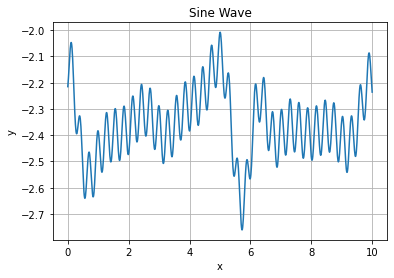

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot a sine wave
def plot_sine_wave(A, f, phi, C):
    # Generate an array of x values (time)
    x = np.linspace(0, 10, 1000)  # 1000 points from 0 to 10
    
    A = 0.2 * np.sin(2 * np.pi * 0.18 * x+2) + 0.1
    
    phi = 4.2 * np.sin(2 * np.pi * 0.158 * x + 0.2) + 0.5
    C = 0.1 * np.sin(2 * np.pi * 3.48 * x - 1.1) - 2.4
    # Calculate the corresponding y values using the sine function
    y = A * np.sin(2  * f * x + phi) + C
    
    #A = np.sin(2 * np.pi * 8 * x+1.1)
    
    #phi = np.sin(2 * np.pi * 80 * x-0.22)
    #C = 0.3 * np.sin(2 * np.pi * 1.48 * x)
    # Calculate the corresponding y values using the sine function
    y = A * np.sin(2  * f * x + phi) + C
    
    
    # Plot the sine wave
    plt.plot(x, y, label=f'Sine Wave: A={A}, f={f}, phi={phi}, C={C}')
    
    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sine Wave')
    
    
    # Show the plot
    plt.grid(True)
    plt.show()

# Example parameters
A = 2      # Amplitude
f = 0.5    # Frequency in Hz
phi = np.pi / 4  # Phase shift (radians)
C = 1      # Vertical shift

# Plot the sine wave with the given parameters
plot_sine_wave(A, f, phi, C)
#this is it.  you can make so much shit with these.  then this is the t amd mix them up.  

In [ ]:
chatgpt shit the bed.  build this tomorrow.  i think its something. we arent tuning frequency, we are just learning the next t (same thing, don't tell god)
                                                                                                                                

In [135]:

import torch
import torch.nn as nn

class WeirdSinLayer(nn.Module):
    def __init__(self):
        super(WeirdSinLayer, self).__init__()
        
        self.param_A = nn.Parameter(torch.randn(1, 3))  # Amplitude
        #self.param_f = nn.Parameter(torch.randn(1, 3))  # Frequency
        self.param_phi = nn.Parameter(torch.randn(1, 3))  # Phase shift
        self.param_C = nn.Parameter(torch.randn(1, 3))  # Vertical shift

    def forward(self, t):
        if t.dim() == 1:
            t = t.unsqueeze(-1)  #may not be necessary, i forget how my dataloader do it

        out_params = self.param_A * torch.sin( t + self.param_phi) + self.param_C
        
        out_A = out_params[:, 0].unsqueeze(-1)  
        out_phi = out_params[:, 1].unsqueeze(-1)      
        out_C = out_params[:, 2].unsqueeze(-1) 
        
        out_t = out_A * torch.sin(t + out_phi) + out_C
        
        return out_t
    

# Example usage
layer = WeirdSinLayer()
t = torch.linspace(0, 1, 2)  # Example input with shape [10]
output = layer(t)  # Output will have shape [10, 3]
print(output.shape)

torch.Size([2, 1])


In [97]:
def run_in_batches(model, data_t, batch_size=32):
    # Ensure the data_t is a tensor
    if not isinstance(data_t, torch.Tensor):
        data_t = torch.from_numpy(data_t)
    
    # Initialize an empty list to store the outputs
    all_outputs = []
    
    # Split data_t into batches
    for i in range(0, len(data_t), batch_size):
        # Select the current batch
        batch = data_t[i:i + batch_size]
        
        # Run the batch through the model
        with torch.no_grad():  # Disable gradient tracking
            batch_outputs = model(batch)
        
        # Append the batch outputs to the list
        all_outputs.append(batch_outputs)
    
    # Concatenate all the outputs along the 0th dimension
    final_output = torch.cat(all_outputs, dim=0)
    
    return final_output

In [186]:
class WeirdSinNetworkInc(nn.Module):
    def __init__(self, num_layers):
        super(WeirdSinNetworkInc, self).__init__()
        
        # Dynamically create the specified number of WeirdSinLayer layers
        self.layers = nn.ModuleList([WeirdSinLayer() for _ in range(num_layers)])
        for idx,layer in enumerate(self.layers):
            #print(layer.param_A)
            additive = torch.tensor([idx]).unsqueeze(-1).float()
            layer.param_A = nn.Parameter(layer.param_A + additive)
            #print(layer.param_A)

    def forward(self, t):
        # Pass the input through each layer in sequence
        for layer in self.layers:
            t = layer(t)
        return t

In [187]:
num_layers = 20 # Let's say we want 5 layers in the network
network = WeirdSinNetworkInc(num_layers)

In [188]:
data_t = torch.from_numpy(np.linspace(1,10000,1000)) #this is interesting.  of course there is infinite wave between every point but this allows a lot of t in range, i think this gap and the way you init has something related.  can this make convergence easier?
outputs = run_in_batches(network, data_t, batch_size=32)

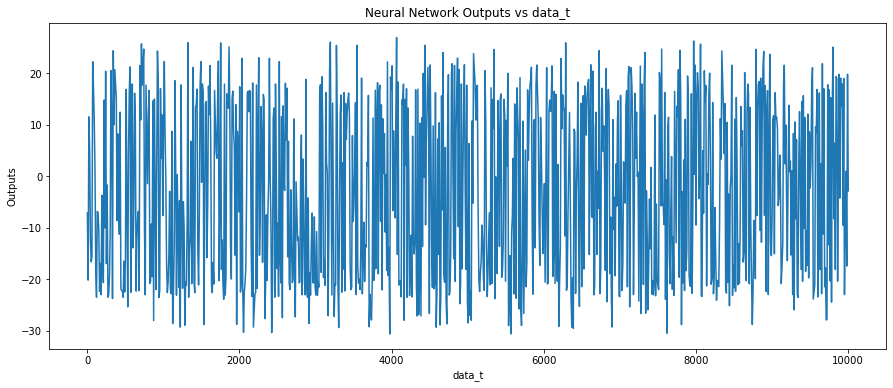

In [189]:
data_t_np = data_t.numpy()  # Convert data_t to numpy array
outputs_np = outputs.detach().numpy().flatten()  # Convert outputs to numpy array and flatten

# Plot
plt.figure(figsize=(15, 6))
plt.plot(data_t_np, outputs_np)
plt.xlabel('data_t')
plt.ylabel('Outputs')
plt.title('Neural Network Outputs vs data_t')
plt.show()

In [131]:
network.layers[-1]

WeirdSinLayer()

In [134]:
import numpy as np

def generate_gaussian_noise(outputs, mean=0, std_dev=1):
    """
    Generate Gaussian noise over a time period `t` with the same shape as the given outputs.
    
    Parameters:
    - outputs: np.ndarray, The output data you want to add noise to. This defines the shape of the noise.
    - t: int, The time period over which to generate noise. This corresponds to the time dimension.
    - mean: float, The mean of the Gaussian noise (default is 0).
    - std_dev: float, The standard deviation of the Gaussian noise (default is 1).
    
    Returns:
    - noise: np.ndarray, The generated Gaussian noise with the same shape as `outputs`.
    """
    
    # Get the shape of the outputs
    shape = outputs.shape
    
    
    # Generate Gaussian noise with the same shape as the outputs
    noise = torch.normal(mean=mean, std=std_dev, size=shape)
    
    return noise


# Generate Gaussian noise with mean 0 and standard deviation 0.1
noise = generate_gaussian_noise(outputs, mean=0, std_dev=0.1)

print(noise.shape)


torch.Size([10000, 1])


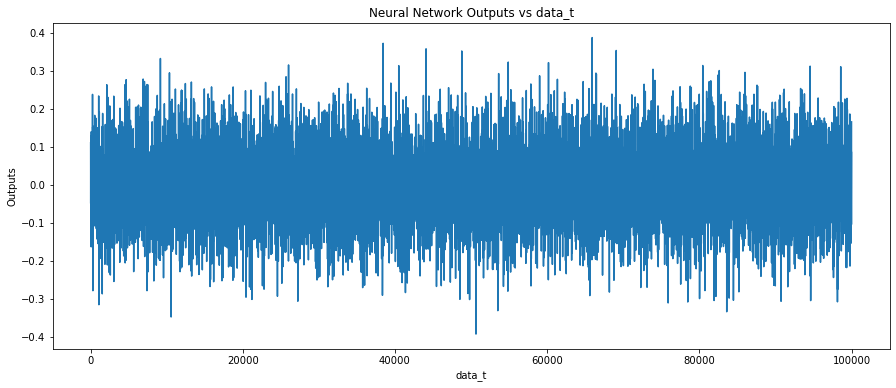

In [126]:
plt.figure(figsize=(15, 6))
plt.plot(data_t_np, noise)
plt.xlabel('data_t')
plt.ylabel('Outputs')
plt.title('Neural Network Outputs vs data_t')
plt.show()

In [ ]:
#can it learn noise? that is, i mean, a difficult wave yes?
#also, is it possibly beneficial to train on noise, and then on a wave? is that a better starting point? 
#if thats the case you may only need to do that once, record the starting weights, and init using those.  a thought.  
#maybe even a good one lol.
